# Mapper 2 example notebook
- Mapper 2, modification of viewser3 Remco procedure
- Allows for built in customization of the map scales
- Allows for addition of background using OpenStreetMap project Stamen Design tiles
- Simplifies label creation in case of recursive map writing
- Simplifies bounding box lookup
- cmap still specifies color, defaults to rainbow if no color is selected

## Mapper2 new customizable scaling

- Majority of the functionality is pushed forward from Mapper1, additional functions introduced below

In [1]:
#obtain data, country month
from viewser import Queryset, Column

queryset = (Queryset("Mapper_tester_cm", "country_month")
            # CONFLICT TYPES NOT LOGGED and NOT time lagged
            .with_column(Column("ged_best_sb", from_table="ged2_cm", from_column="ged_sb_best_sum_nokgi")
                         .transform.missing.fill()
                         )
            # .with_column(Column('name', from_table='country', from_column= 'name')
            # the above does not seem to want to work

            .with_theme("fatalities")

            .describe("""Fatalities conflict history, cm level
            Mapper testing

            """)

            )

cm_master = queryset.publish().fetch()

 .    

In [2]:
#fetch the multipolygons for mapping
import geopandas as gpd
import sqlalchemy as sa
from ingester3.config import source_db_path

engine = sa.create_engine(source_db_path)
gdf_ci_master = gpd.GeoDataFrame.from_postgis(
    "SELECT id as country_id, in_africa, in_me, geom FROM prod.country",
    engine,
    geom_col='geom'
)
gdf_ci_master = gdf_ci_master.to_crs(4326)

In [3]:
#Mapper2 
from views_mapper2.mapper2 import *

In [4]:
#specify savefile in case of save procedure
import os
home = os.path.expanduser("~")
folder = '/Desktop/'
filename = home+folder+'test.png'

In [5]:
#specify scale or dictionary
#please note you can create your own customized dictionary with values and labels
#use one of the dictionary writers to create a customized dictionary
#use one of standard dictionaries 
    #(standard dictionary, dictionary for lop1p transformed values, dictionary for log2p transformed values)

from views_mapper2.dictionary_writer import *

In [6]:
display(dictionary_stand, dictionary_stand_1p, dictionary_stand_2p)

{'0': 0, '100': 100, '300': 300, '1000': 1000, '3000': 3000}

{'0': 0.0,
 '1': 0.6931471805599453,
 '3': 1.3862943611198906,
 '10': 2.3978952727983707,
 '30': 3.4339872044851463,
 '100': 4.61512051684126,
 '300': 5.707110264748875,
 '1000': 6.90875477931522,
 '3000': 8.006700845440367}

{'0': 0.0,
 '1': 0.5265890341390445,
 '3': 0.8697416861919438,
 '10': 1.223156202527103,
 '30': 1.4892992254175486,
 '100': 1.7254630513334037,
 '300': 1.9031681972312866,
 '1000': 2.067970345786057,
 '3000': 2.1979688386872795}

In [7]:
#how to use custom dictionary writer
#since we only have normal values and no log or twice log transformed values, use normal dictionary writer
custom_scale = [0, 10, 55, 68, 100, 673]
dictionary_custom = norm_dict(custom_scale)

#hand created dictionary
dictionary_ludicrous = {'apple':0, 'lemon':100, 'kiwi':200, 'banana':300, 'pear':400}

Mapper2 allows for the customizable addition of scaling to the map.
Map scale sets the scales to a custom range, displays values of the variable as is.
Map dictionary sets both scale and labels to custom.
Map dictionary writer can be used to create dictionaries from scale values.

Mapper2 preferentially looks for map_dictionary, if not found looks for map_scale, if fails on both defaults to Remco procedure (i.e., max and min within the sample). For stability please specify either map_scale or map_dictionary only.

colorbar and ticklabels no longer need to be specified, the writing has been automated in the code

ViewsBox and additional layers can be added per Remco Procedure. (Refer to Mapper1)

Background allows for Background map and labels sandwiching of the map using the Standard Stamen Design tiles from  Open Street Map project. Available in grey and colorful versions, with options 'grey' or 'color'.

Save procedure identical to previous versions. 

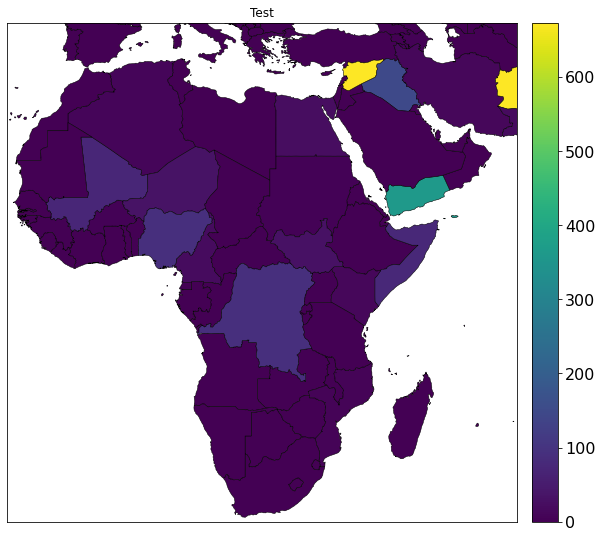

In [8]:
#Please note that much like previous iteration, mapper2 builds layers
#showcasing custom_scale
data= cm_master.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

test=Mapper2(
    width=10,
    height=10,
    frame_on=True,
    title="Test",
    bbox=[-18.5, 64.0, -35.5, 43.0],
).add_layer(
    gdf=gdf.loc[457],
    map_scale = custom_scale,
    cmap='viridis',
    edgecolor="black",
    linewidth=0.5,
    column="ged_best_sb"
)

#test.save(filename)

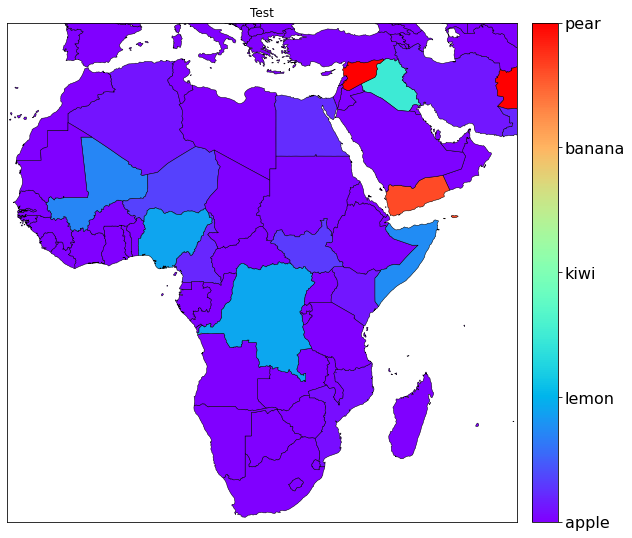

In [9]:
#Use of custom dictionary
data= cm_master.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

test=Mapper2(
    width=10,
    height=10,
    frame_on=True,
    title="Test",
    bbox=[-18.5, 64.0, -35.5, 43.0],
).add_layer(
    gdf=gdf.loc[457],
    map_dictionary = dictionary_ludicrous,
    cmap=None,
    edgecolor="black",
    linewidth=0.5,
    column="ged_best_sb"
)

#test.save(filename)

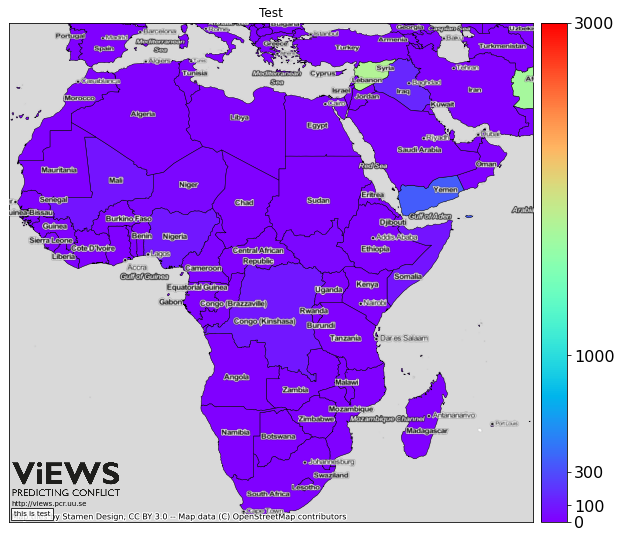

In [10]:
#adding background map
data= cm_master.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

textbox = 'this is test'

test=Mapper2(
    width=10,
    height=10,
    frame_on=True,
    title="Test",
    bbox=[-18.5, 64.0, -35.5, 43.0],
).add_layer(
    gdf=gdf.loc[457],
    map_dictionary = dictionary_stand,
    background = 'grey',
    cmap=None,
    edgecolor="black",
    linewidth=0.5,
    column="ged_best_sb"
).add_views_textbox(
    text=textbox,
    textsize=12)

#test.save(filename)

In [11]:
#create single and double logged values
cm_master['ln_ged_sb'] = np.log1p(cm_master['ged_best_sb'])
cm_master['ln2_ged_sb'] = np.log1p(cm_master['ln_ged_sb'])

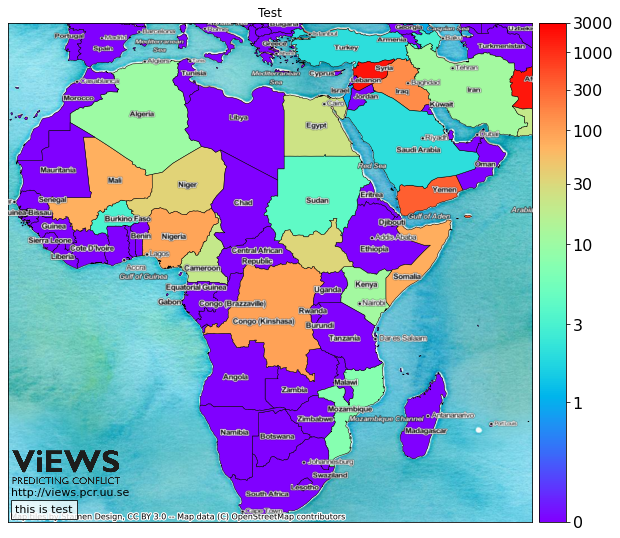

In [12]:
#showcase of 1p/2p log scale
#adding background map, colorful
data= cm_master.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

textbox = 'this is test'

test=Mapper2(
    width=10,
    height=10,
    frame_on=True,
    title="Test",
    bbox=[-18.5, 64.0, -35.5, 43.0],
).add_layer(
    gdf=gdf.loc[457],
    map_dictionary = dictionary_stand_2p,
    background = 'color',
    cmap=None,
    edgecolor="black",
    linewidth=0.5,
    column="ln2_ged_sb"
).add_views_textbox(
    text=textbox,
    textsize=16)

#test.save(filename)

# BBox Writer
- simplifies lookup of bbox that one might want to use
- bbox for africa and africa+middle east available when using 'africa' or 'ame' respectively
- requires user to know country_id
- please note that some of the countries have poor coverage with OpenWorldMap tiles and can lack labels
- extremely northern countries tend to have issues with individual bbox, e.g., Russian Federation


In [13]:
from views_mapper2.BBoxWriter import *

In [14]:
bbox1 = bbox_from_cid('africa')
bbox2 = bbox_from_cid('ame')
bbox3 = bbox_from_cid(81)
display(bbox1, bbox2, bbox3)

[-18.5, 52.0, -35.5, 38.0]

[-18.5, 64.0, -35.5, 43.0]

[-5.1, 6.8, 1.1, 16.1]

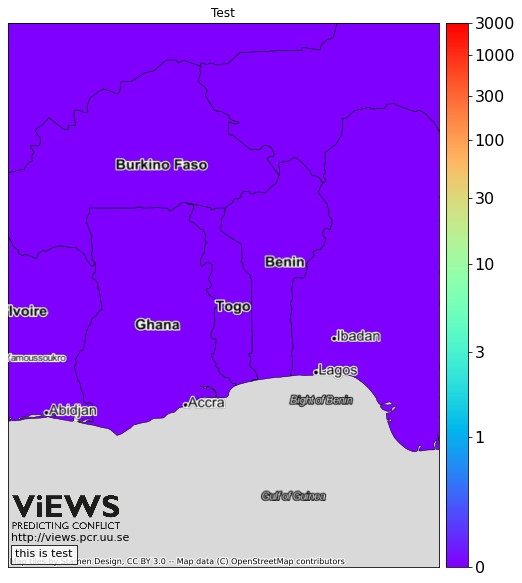

In [15]:
#mapper using the custom bbox
data= cm_master.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

textbox = 'this is test'

test=Mapper2(
    width=10,
    height=10,
    frame_on=True,
    title="Test",
    bbox=bbox3,
).add_layer(
    gdf=gdf.loc[360],
    map_dictionary = dictionary_stand_2p,
    background = 'grey',
    cmap=None,
    edgecolor="black",
    linewidth=0.5,
    column="ln2_ged_sb"
).add_views_textbox(
    text=textbox,
    textsize=16)

#test.save(filename)

## Other functions
- small functions that take advantage of Ingester for simplification of recursive map code writing or QOL improvements
- vid2date creates a data string from month_id
- date2id creates a month_id from date in iso format, e.g. '2010-04-01'
- cid2name create a name from country_id
- name2iso converts name into iso or uses soft suggestion if incorrect
- name_mid2cid converts name and month id into country_id
- name_date2cid converts name and iso date into country_id

In [16]:
from views_mapper2.label_writer import *

In [17]:
test1 = vid2date(121)
test2 = date2id('2010-01-13')
print(test1, test2)

1990/1 361


In [18]:
test3 = cid2name(79)
test3

Nigeria


In [19]:
test4 = name_mid2cid('Togo', 361)
test4

81

In [20]:
test5 = name2iso('United Kingdom')
test5

'GBR'

In [21]:
#example of soft search
test6 = name_mid2cid('England', 121)
test6

"no match, did you mean Country(alpha_2='GB', alpha_3='GBR', name='United Kingdom', numeric='826', official_name='United Kingdom of Great Britain and Northern Ireland')"

## Functionality with PG level
- Similar to the above and previous Remco procedure
- Note that boundaries for countries has not been resolved

In [22]:
queryset = (Queryset("m_fatalities_conflict_pgm", "priogrid_month")
              #CONFLICT TYPES NOT LOGGED and NOT time lagged 
            .with_column(Column("ged_best_sb", from_table = "ged2_pgm", from_column = "ged_sb_best_sum_nokgi")
                         .transform.missing.fill()
                        )
            .with_column(Column("ged_best_ns", from_table = "ged2_pgm", from_column = "ged_ns_best_sum_nokgi")
                         .transform.missing.fill()
                        )
            .with_column(Column("ged_best_os", from_table = "ged2_pgm", from_column = "ged_os_best_sum_nokgi")
                         .transform.missing.fill()
                        )
            
              #log transformed
            .with_column(Column("ln_ged_sb", from_table = "ged2_pgm", from_column = "ged_sb_best_sum_nokgi")
                         .transform.ops.ln()
                         .transform.missing.fill()
                        )
            .with_column(Column("ln_ged_ns", from_table = "ged2_pgm", from_column = "ged_ns_best_sum_nokgi")
                         .transform.ops.ln()
                         .transform.missing.fill()
                        )
            .with_column(Column("ln_ged_os", from_table = "ged2_pgm", from_column = "ged_os_best_sum_nokgi")
                         .transform.ops.ln()
                         .transform.missing.fill()
                        )
                
            #.with_column(Column('name', from_table='country', from_column= 'name')
            #the above does not seem to want to work 
                         
            .with_theme("fatalities")
                         
            .describe("""Fatalities conflict history, pgm level
            Fatalities description 
                
            """)
            
           )

pg_master = queryset.publish().fetch()

 .    

In [23]:
pg_master['ln2_ged_sb'] = np.log1p(pg_master['ln_ged_sb'])
pg_master['ln2_ged_ns'] = np.log1p(pg_master['ln_ged_ns'])
pg_master['ln2_ged_os'] = np.log1p(pg_master['ln_ged_os'])

In [24]:
engine = sa.create_engine(source_db_path)
gdf_pid_master = gpd.GeoDataFrame.from_postgis(
    "SELECT id as pg_id, geom FROM prod.priogrid", 
    engine, 
    geom_col='geom'
)
gdf_pid_master = gdf_pid_master.to_crs(4326)

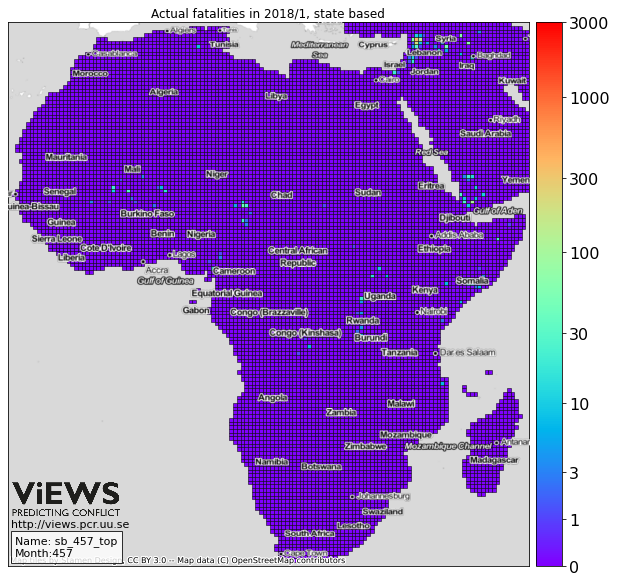

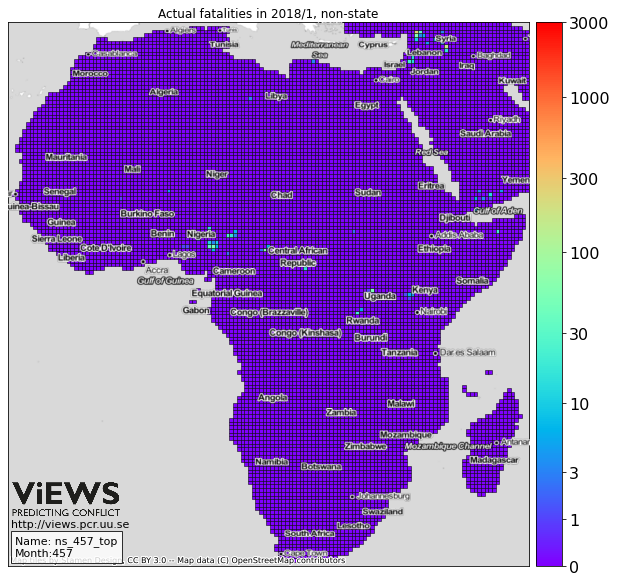

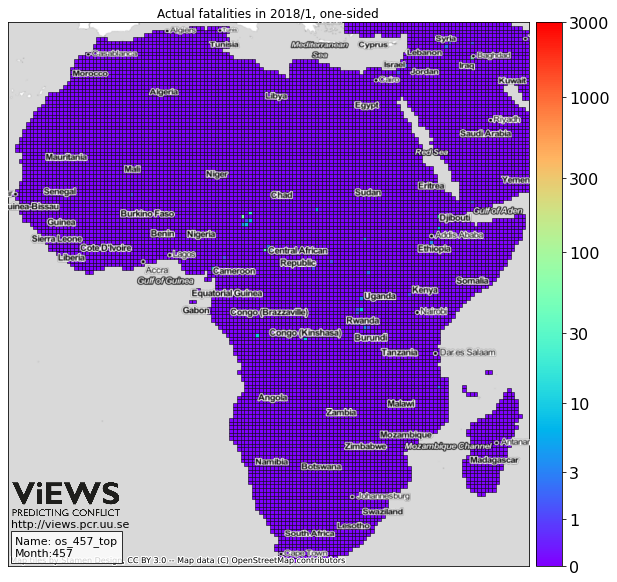

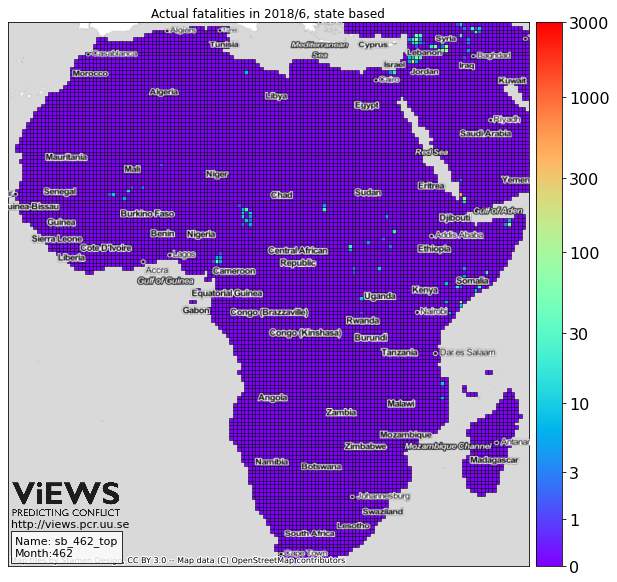

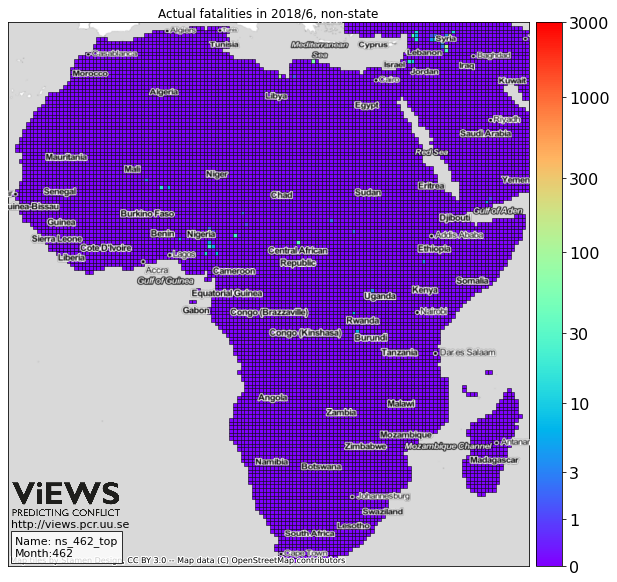

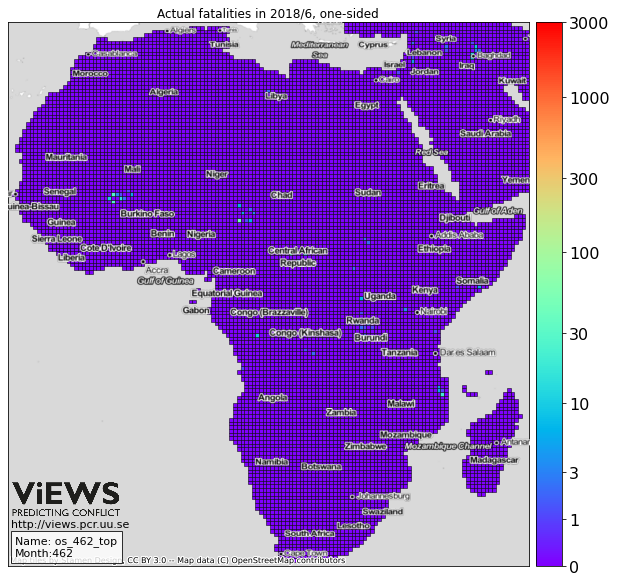

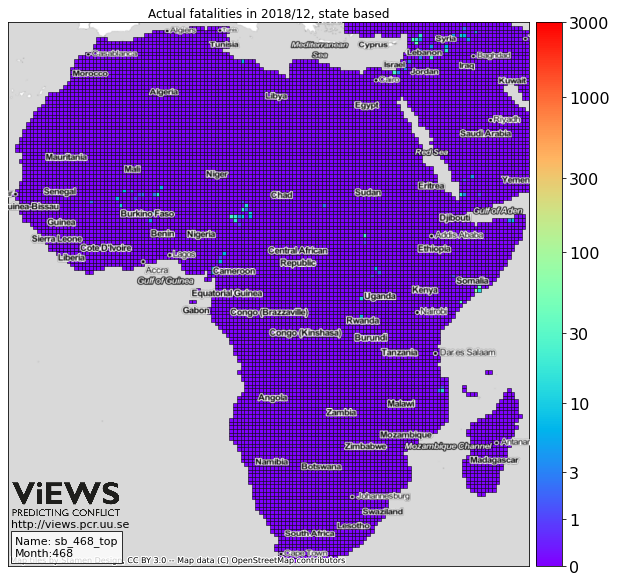

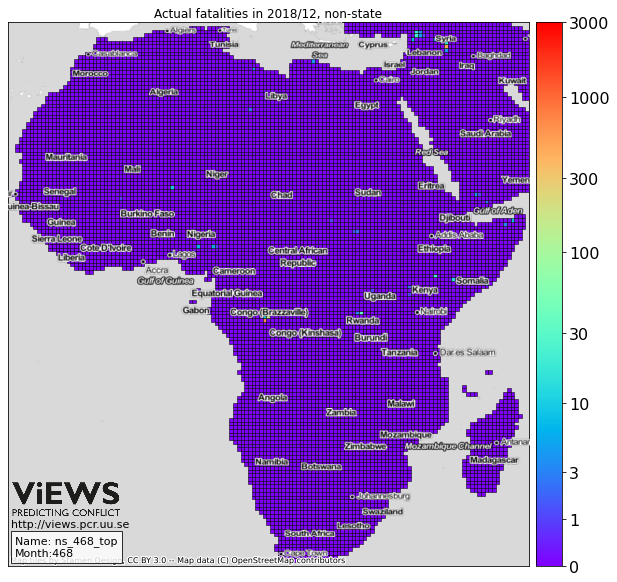

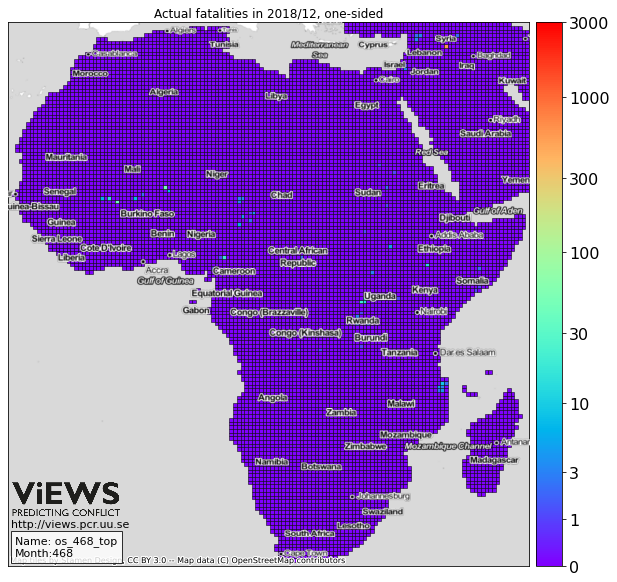

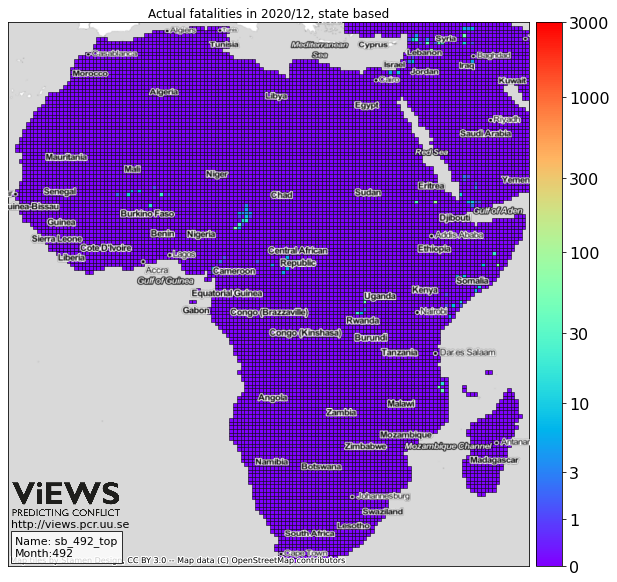

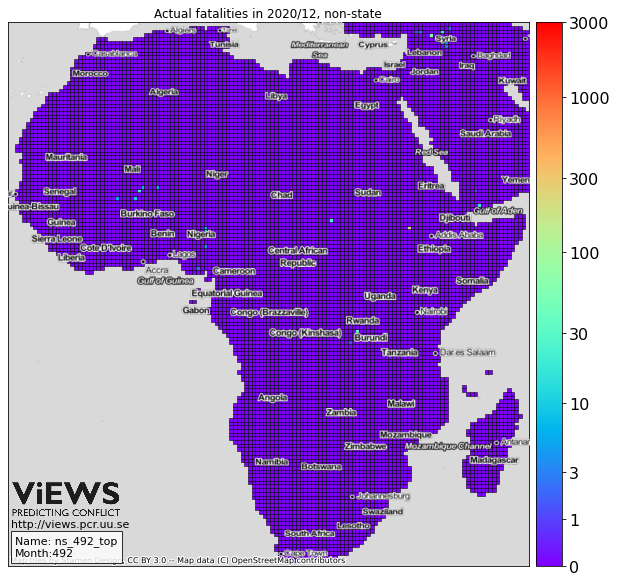

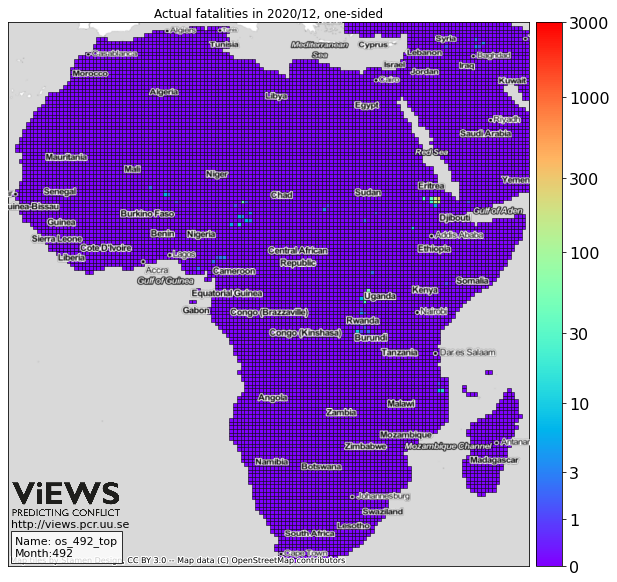

In [28]:
data_pid = pg_master.copy()
gdf = gdf_pid_master.copy()
gdf['priogrid_gid'] = gdf['pg_id']
data_pid = data_pid.join(gdf.set_index("priogrid_gid"))
gdf = gpd.GeoDataFrame(data_pid, geometry="geom")

list_of_months = [457, 462, 468, 492]
list_of_fatalities = ['sb', 'ns', 'os']
fat_labels = ['state based', 'non-state', 'one-sided']
fact_dict =dict(zip(list_of_fatalities, fat_labels))

dictionary_for_run = dictionary_stand_1p
scale_for_run_name_string = '_log_scale'
my_path = home+'/Desktop/'

for i in list_of_months:
    for key, value in fact_dict.items():
        variable_def = 'ln_ged_' + key
        title_def = 'Actual fatalities in ' + str(vid2date(i)) + ', ' + value
        textbox = 'Name: '+ key + '_' + str(i) + '_top\nMonth:' + str(i)
        savefile = 'pgm_'+str(i)+key+scale_for_run_name_string
        m=Mapper2(
            width=10,
            height=10,
            frame_on=True,
            title=title_def,
            bbox=bbox_from_cid('africa'),
        ).add_layer(
            gdf=gdf.loc[i],
            map_dictionary=dictionary_for_run,
            background = 'grey',
            cmap='rainbow',
            edgecolor="black",
            linewidth=0.5,
            column=variable_def
        ).add_views_textbox(
            text=textbox,
            textsize=16)
        #m.save(my_path+savefile)

### Yet to be done, determine how to overlay country boundaries, apprpriate zoom into the countries has been achieved

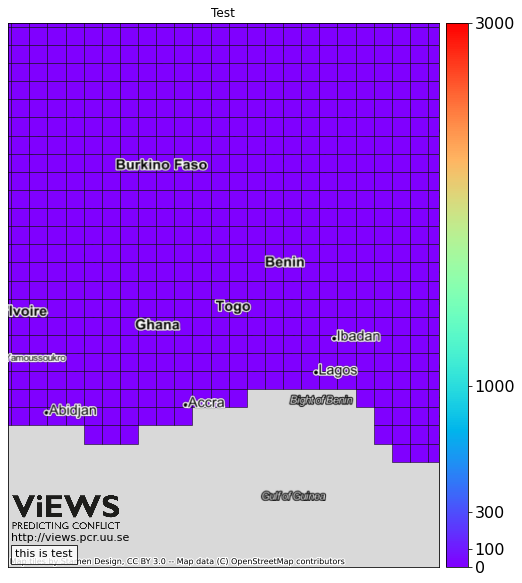

In [26]:
#note the use of appropriate bounding box, but the country boundaries have not yet been implemented
data_pid = pg_master.copy()
gdf = gdf_pid_master.copy()
gdf['priogrid_gid'] = gdf['pg_id']
data_pid = data_pid.join(gdf.set_index("priogrid_gid"))
gdf = gpd.GeoDataFrame(data_pid, geometry="geom")

test=Mapper2(
    width=10,
    height=10,
    frame_on=True,
    title="Test",
    bbox=bbox3,
).add_layer(
    gdf=gdf.loc[360],
    map_dictionary = dictionary_stand,
    background = 'grey',
    cmap=None,
    edgecolor="black",
    linewidth=0.5,
    column="ged_best_sb"
).add_views_textbox(
    text=textbox,
    textsize=16)